# Finding parameters for MEMS

The plan is to use FPGA for instant acceleration cancelation.  
We have been testing this method on the gravimeter. The idea is to use FPGA to simulate AI and compare the results with the experimental data to look for difference.  
The difference should reveal bias and scaling factor instability.

## Challenges

FPGA needs to interprete the MEMS data correctly, so that the measurement scale of the MEMS is matched with the interferometer. This is a task requires fine tuning.  
We are trying to measure gravimeter with a vibration on the top. To compensate this signal on AI, the calculated output of FPGA needs to lie within $0$ and $2 \pi$. Because the interferoemter phase corresponding to the gravimeter is a large number, the $2\pi$-conversion of the estimated signal is highly sensitive to the used scaling factor of the MEMS.  

We have tried to visually analyse any compensation effect by setting the integer part of the quotient to be the calculated value using the dynamica range of the interferomter.  

A compensation effect will be demonstrated later in the notebook, however, there is no drastic improvement on the compensation effectivement. This leads us to pursue a more quantitative measure by looking/minimising at the fringe residuals.

## Method 1 - With post correction

Using FPGA to reproduce post correction. This should be able to give us a more accurate guess for the MEMS parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

getting AI data

In [163]:
def getaidata(filepath):
    ai=pd.read_table(filepath+"/"+os.listdir(filepath+"/")[0], names=["Phase","P2"])[-1:0:-1]
    ai.reset_index(inplace=True,drop=True)
    return ai

In [171]:
ai20ms=getaidata("2T_20ms")
ai6ms1=getaidata("2T_6ms_1")
ai6ms2=getaidata("2T_6ms_2")

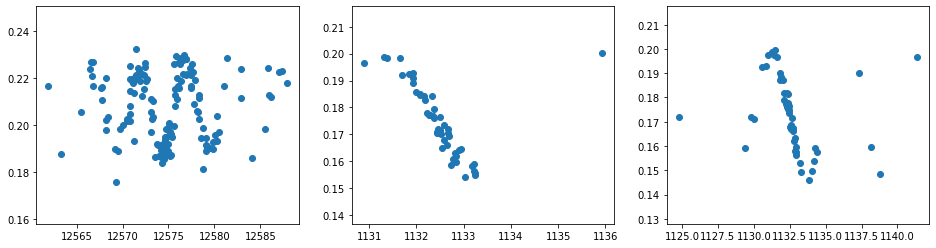

In [172]:
b=150
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
ax[0].scatter(ai20ms["Phase"][:b],ai20ms["P2"][:b])
ax[1].scatter(ai6ms1["Phase"],ai6ms1["P2"])
ax[2].scatter(ai6ms2["Phase"],ai6ms2["P2"])

Let us only use the first 150 data points. The laser power seemed to have dropped since then.

Getting FPGA data

In [168]:
def getfpgadata(filepath, fileheader):
    
    fpgafile = np.sort([file for file in os.listdir(filepath+"/") if fileheader in file])
    fpga=[pd.read_csv(filepath+"/"+fpgafile[i],names=[str(i)])[1:].astype(float).values.T.tolist()[0] for i in range(len(fpgafile))]
    fpga =pd.DataFrame(fpga).T
    return fpga

In [173]:
fpga20ms = getfpgadata("2T_20ms","20_07")
fpga6ms1 = getfpgadata("2T_6ms_1","20_07")
fpga6ms2 = getfpgadata("2T_6ms_2","20_07")

Let us compute the post corrected signal

2000


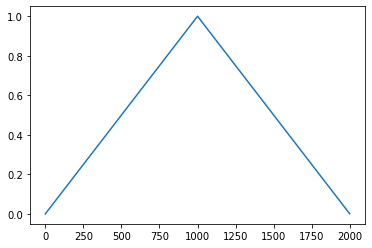

In [346]:
senFct = lambda TT, dt: np.array([t if t<=TT/2 else TT-t for t in np.arange(0,TT,dt)])*2/TT
print(len(senFct(0.02,0.00001)))
plt.plot(senFct(0.02,0.00001))

### Comparing MEMS data

In [154]:
mems20ms=pd.read_table("2T_20ms/"+filelist20ms[1]).T
mems20ms.reset_index(inplace=True,drop=True)

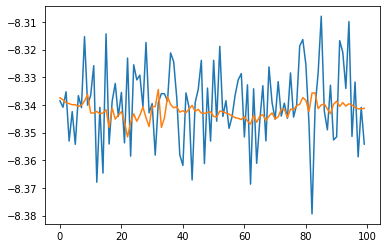

In [162]:
datanr= 2

tempLabview=[]
for i in range(int(len(mems20ms[datanr])/50)):
    tempLabview.append(mems20ms[datanr][i*50:(i+1)*50].mean())

tempFPGA=[]
for i in range(int(len(fpga20ms[datanr])/20)):
    tempFPGA.append(fpga20ms[datanr][i*20:(i+1)*20].mean())
plt.plot(tempFPGA)
plt.plot(tempLabview[-100:])

The above graph is with the mems data averaged down to 5kHz. Even after averaging, FPGA show a huge noise compared with USB DAQ Card.

### Ideal Case

Let us consider the idea case: no delay

In [388]:
dt = 0.00001
TT=0.02
keff = 4*np.pi/0.00000078

In [348]:

idealDF20ms = ai20ms.copy()
idealDF20ms.reset_index(inplace=True, drop=True)

idealDF6ms1 = ai6ms1.copy()
idealDF6ms1.reset_index(inplace=True, drop=True)

idealDF6ms2 = ai6ms2.copy()
idealDF6ms2.reset_index(inplace=True, drop=True)

In [349]:
idealDF20ms["FPGA_Phase"] = [np.sum(senFct(0.02,dt)*fpga20ms.iloc[:,i].shift()) for i in range(len(fpga20ms.columns))][0:300]
idealDF6ms1["FPGA_Phase"] = [np.sum(senFct(0.006,dt)*fpga6ms1.iloc[:,i].shift()) for i in range(len(fpga6ms1.columns))][0:50]
idealDF6ms2["FPGA_Phase"] = [np.sum(senFct(0.006,dt)*fpga6ms2.iloc[:,i].shift()) for i in range(len(fpga6ms2.columns))][0:50]

In [350]:
idealDF6ms1["FPGA_Phase"][-(5-5):-(45+1):-1]

Series([], Name: FPGA_Phase, dtype: float64)

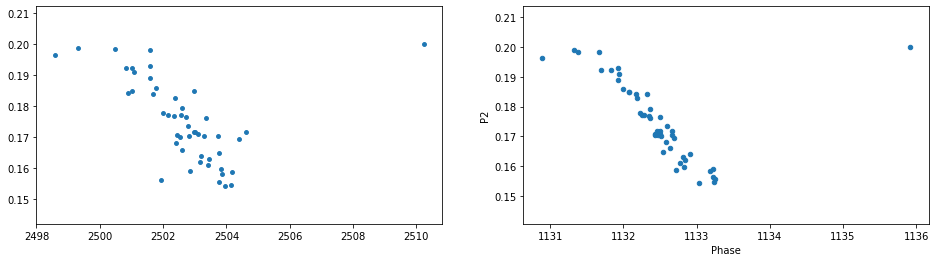

In [351]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].scatter(-idealDF6ms1["FPGA_Phase"][-1:-50:-1],idealDF6ms1["P2"][1:50],s=15)
idealDF6ms1[1:50].plot.scatter(x="Phase",y="P2",ax=ax[1])

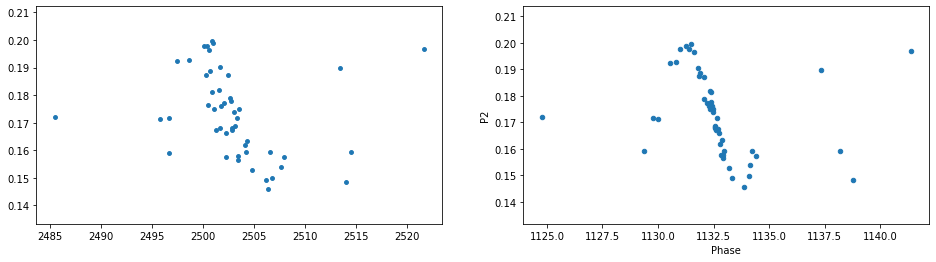

In [352]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].scatter(-idealDF6ms2["FPGA_Phase"][-(1):-50:-1],idealDF6ms2["P2"][1:50],s=15)
idealDF6ms2[1:50].plot.scatter(x="Phase",y="P2",ax=ax[1])

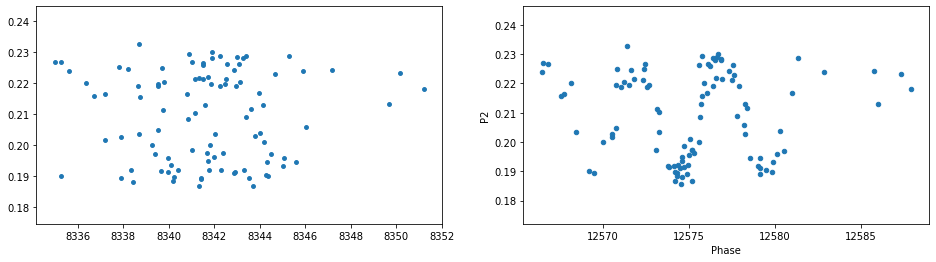

In [353]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].scatter(-idealDF20ms["FPGA_Phase"][-1:-100:-1],idealDF20ms["P2"][1:100],s=15)
idealDF20ms[0:100].plot.scatter(x="Phase",y="P2",ax=ax[1])

I think that the noise on the FPGA is causing the fringe to vanish. 

#### Data set 1: 6 ms set 2

In [354]:
from scipy import optimize

def model(x, p0,c,eta,phi0):
    return p0 + c * np.cos(eta*x+phi0)

In [377]:
reslist=[]
delaylist=np.arange(-140,10,1)
for j in delaylist:
    xdata=[np.sum(senFct(0.006,dt)*fpga6ms2.iloc[:,i].shift(j)) for i in range(len(fpga6ms2.columns))][0:50][-(1):-50:-1]
    ydata=idealDF6ms2["P2"][1:50]
    parms, pcov = optimize.curve_fit(model, xdata, ydata, p0=[0.18,0.03,0.55,0])
    reslist.append(np.std(ydata-model(np.array(xdata),parms[0],parms[1],parms[2],parms[3])))

Text(0, 0.5, 'std of residuals')

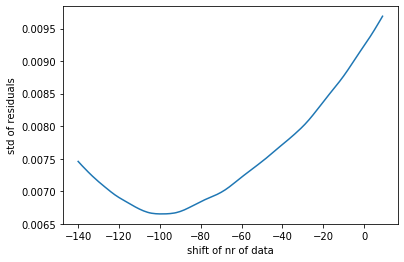

In [378]:
plt.plot(delaylist,reslist)
plt.xlabel("shift of nr of data")
plt.ylabel("std of residuals")

Let us visualise them.

In [373]:
idealDF6ms2["FPGA_Phase_new"] = [np.sum(senFct(0.006,dt)*fpga6ms2.iloc[:,i].shift(-100)) for i in range(len(fpga6ms2.columns))][0:50]

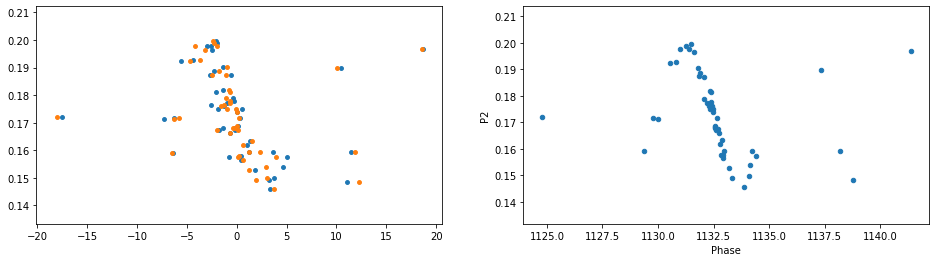

In [374]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].scatter(-idealDF6ms2["FPGA_Phase"][-(1):-50:-1]-(-idealDF6ms2["FPGA_Phase"][-(1):-50:-1]).mean(),idealDF6ms2["P2"][1:50],s=15)
ax[0].scatter(-idealDF6ms2["FPGA_Phase_new"][-(1):-50:-1]-(-idealDF6ms2["FPGA_Phase_new"][-(1):-50:-1]).mean(),idealDF6ms2["P2"][1:50],s=15)
idealDF6ms2[1:50].plot.scatter(x="Phase",y="P2",ax=ax[1])

Still pretty bad. Lets look at the other data sets.

#### Dataset 2: 6ms 1

In [337]:
reslist=[]
delaylist=np.arange(-140,10,1)
for j in delaylist:
    xdata=[np.sum(senFct(0.006,dt)*fpga6ms1.iloc[:,i].shift(j)) for i in range(len(fpga6ms1.columns))][0:50][-(1):-50:-1]
    ydata=idealDF6ms1["P2"][1:50]
    parms, pcov = optimize.curve_fit(model, xdata, ydata, p0=[0.18,0.04,182,0])
    reslist.append(np.std(ydata-model(np.array(xdata),parms[0],parms[1],parms[2],parms[3])))

Text(0, 0.5, 'std of residuals')

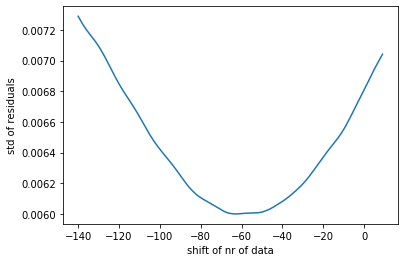

In [338]:
plt.plot(delaylist,reslist)
plt.xlabel("shift of nr of data")
plt.ylabel("std of residuals")

Let us visualise them.

In [339]:
idealDF6ms1["FPGA_Phase_new"] = [np.sum(senFct(0.006,dt)*fpga6ms1.iloc[:,i].shift(-60)) for i in range(len(fpga6ms1.columns))][0:50]

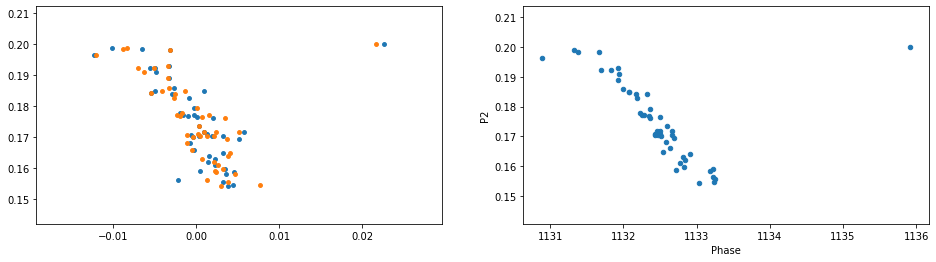

In [340]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].scatter(-idealDF6ms1["FPGA_Phase"][-(1):-50:-1]-(-idealDF6ms1["FPGA_Phase"][-(1):-50:-1]).mean(),idealDF6ms1["P2"][1:50],s=15)
ax[0].scatter(-idealDF6ms1["FPGA_Phase_new"][-(1):-50:-1]-(-idealDF6ms1["FPGA_Phase_new"][-(1):-50:-1]).mean(),idealDF6ms1["P2"][1:50],s=15)
idealDF6ms1[1:50].plot.scatter(x="Phase",y="P2",ax=ax[1])

## Method 2 - Fringe scanning with compensation

We scanned the FPGA output from 0 to 8.5, corresponds to a $2\pi$ scan. On top of the these the compensation phase is added. 

In [389]:
xdata=[np.sum(senFct(0.006,dt)*fpga6ms2.iloc[:,i].shift(-100)) for i in range(len(fpga6ms2.columns))][0:50][-(1):-50:-1]
ydata=idealDF6ms2["P2"][1:50]
parms, pcov = optimize.curve_fit(model, xdata, ydata, p0=[0.18,0.03,0.75,0])

In [390]:
parms[2]/(keff*dt)

0.003427692792261549

In [391]:
keff

16110731.556870732